# Final Simulation of Singular Routes

In [160]:
import main_1 as m
import models.road_network.create_graph as cg
import models.vehicle_models.battery_deg as bd
import scipy.stats as stats

import json
from pprint import pprint
import matplotlib.pyplot as plt
import simulation.simulate_routes as sr
import datetime
import os
import numpy as np


In [ ]:
road_network_file, road_df, static_data, vehicle_data, battery_data, map_data, weights = m.import_data()

In [ ]:
OCV = battery_data["OCV"]
capacity = battery_data["Capacity"]
R_int = battery_data["R_internal"]
motor_eff = vehicle_data["motor_eff"]
graph = cg.create_osmnx_compatible_graph(road_network_file, debug = False)

In [ ]:
# m.create_new_test_set(road_df)

In [ ]:
with open("test_data/test_route_set.json", "r") as file:
        test_routes_dict = json.load(file)

## Simulate a Set of Routes

In [ ]:
def simulate(results_log_file,results_filename, test_set_data ):
    simulation_results = {}

    start_time = datetime.datetime.now()
    start_time_str = start_time.strftime("%B %d, %Y at %I:%M:%S %p")

    with open(results_log_file, 'w') as log_file:
        log_file.write(f"{'='*50}\n")
        log_file.write(f"SIMULATION STARTED: {start_time_str}\n")
        log_file.write(f"Output file: {os.path.abspath(results_filename)}\n")
        log_file.write(f"Test set: test_set1\n")
        log_file.write(f"Routes to process: {len(test_set_data)}\n")
        log_file.write(f"{'='*50}\n\n")

# Use enumerate instead of manual counter
    for i, points in enumerate(test_set_data, 1):
        print(f"Processing route {i}/{len(test_set_data)}: {points[0]} to {points[1]}")
        
        # Initialize dictionary entry for this simulation
        simulation_results[f'sim{i}'] = {
            'start_point': points[0],
            'end_point': points[1],
            'optimised': {},
            'distance': {}
        }
        
        try:
            # Calculate optimised route
            route_output_optimised = sr.find_route(
                map_data, road_df, graph, points[0], points[1], 
                weights, plot=False, weights_type='objective'
            )
            
            # Store optimised route data
            opt_results = sr.return_route_data_complex(
                route_output_optimised, vehicle_data, static_data, 
                motor_eff, battery_data
            )
            
            simulation_results[f'sim{i}']['optimised'] = {
                'total_distance': opt_results[0],
                'total_consumption': opt_results[1],
                'total_climb': opt_results[2],
                'detailed_results': opt_results[3],
                'current_list': opt_results[4],
                'climbs': opt_results[5],
                'distances': opt_results[6],
                'consumptions': opt_results[7]
            }
            
            # Calculate distance-based route
            route_output_distance = sr.find_route(
                map_data, road_df, graph, points[0], points[1], 
                weights, plot=False, weights_type='distance'
            )
            
            # Store distance route data
            dist_results = sr.return_route_data_complex(
                route_output_distance, vehicle_data, static_data, 
                motor_eff, battery_data
            )
            
            simulation_results[f'sim{i}']['distance'] = {
                'total_distance': dist_results[0],
                'total_consumption': dist_results[1],
                'total_climb': dist_results[2],
                'detailed_results': dist_results[3],
                'current_list': dist_results[4],
                'climbs': dist_results[5],
                'distances': dist_results[6],
                'consumptions': dist_results[7]
            }
            
            print(f"Route {i}/{len(test_set_data)} complete")
            
        except Exception as e:
            print(f"Error on route {points}: {str(e)}")
            simulation_results[f'sim{i}']['error'] = str(e)

    class CustomEncoder(json.JSONEncoder):
        def default(self, obj):
            # Handle various non-serializable types
            if isinstance(obj, (np.bool_, bool)) or str(type(obj)) == "<class 'bool'>":
                return bool(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            elif isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif hasattr(obj, 'tolist'):
                return obj.tolist()
            elif hasattr(obj, '__dict__'):
                return obj.__dict__
            return super().default(obj)

    # Use this encoder
    with open(results_filename, "w") as file:
        json.dump(simulation_results, file, indent=4, cls=CustomEncoder)

    end_time = datetime.datetime.now()
    end_time_str = end_time.strftime("%B %d, %Y at %I:%M:%S %p")
    total_duration = end_time - start_time

    with open(results_log_file, 'a') as log_file:
        log_file.write(f"\n{'='*50}\n")
        log_file.write(f"SIMULATION COMPLETED: {end_time_str}\n")
        log_file.write(f"Total duration: {total_duration}\n")
        log_file.write(f"Routes processed: {len(test_set_data)}\n")
        log_file.write(f"Results saved to: {os.path.abspath(results_filename)}\n")
        log_file.write(f"{'='*50}\n\n")


In [ ]:
test_set_data = test_routes_dict['test_set5']
results_filename = "results/singular_routes_sim/simulation_test_set5.json"
results_log_file = "./results/singular_routes_sim/simulation_log5.txt"

simulate(results_log_file, results_filename, test_set_data)

## Collect Consumptions for a Set

In [175]:
def collect_consumptions(results_file: str):
    with open(results_file, "r") as file:
        sim_results = json.load(file)

    consumption_dict = {}
    consumptions_distance = []
    consumptions_optimised = []
    for key, values in sim_results.items():
        if f'{key}' not in consumption_dict:
            consumption_dict[f'{key}'] = {}

        found_consumption = False
        for test, test_data in values.items():
            if 'distance' in test:
                for id, item in test_data.items():
                    consumption_dict[f'{key}'][f'{test}'] = test_data['total_consumption']
                    consumptions_distance.append(test_data['total_consumption'])
                    found_consumption = True
                    break
            elif 'optimised' in test:
                for id, item in test_data.items():
                    consumption_dict[f'{key}'][f'{test}'] = test_data['total_consumption']
                    consumptions_optimised.append(test_data['total_consumption'])
                    found_consumption = True
                    break
    if not found_consumption:
        pass
    return consumptions_distance, consumptions_optimised

# cap_loss_distance, cap_loss_optimised = collect_consumptions('results/singular_routes_sim/simulation_test_set1.json')
# print(len(cap_loss_distance))


In [152]:
def collect_ageing(results_file: str):
    with open(results_file, "r") as file:
        sim_results = json.load(file)
    
    results_dict = {}
    cap_loss_optimised = []
    cap_loss_distance = []
    for key, values in sim_results.items():
        # print(key)
        results_dict[key] = {}  # No need for f-string here
        
        for test, test_data in values.items():
            if 'distance' in test:
                for id, item in test_data.items():
                    # Initialize the test dictionary first
                    results_dict[key][test] = {}  # No need for f-string here
                    
                    # Calculate capacity loss using your existing function
                    capacity_loss = bd.route_analysis(
                        test_data['detailed_results'], 
                        test_data['current_list'], 
                        test_data['consumptions'],
                        OCV, 
                        capacity
                    )
                    # Store just the capacity loss result
                    cap_loss_distance.append(capacity_loss)
                    results_dict[key][test]['capacity_loss'] = capacity_loss
                    break
            if 'optimised' in test:
                for id, item in test_data.items():

                    # Initialize the test dictionary first
                    results_dict[key][test] = {}  # No need for f-string here
                    
                    # Calculate capacity loss using your existing function
                    capacity_loss = bd.route_analysis(
                        test_data['detailed_results'], 
                        test_data['current_list'], 
                        test_data['consumptions'],
                        OCV, 
                        capacity
                    )
                    # Store just the capacity loss result
                    cap_loss_optimised.append(capacity_loss)
                    results_dict[key][test]['capacity_loss'] = capacity_loss
                    break
            

                
    return cap_loss_distance, cap_loss_optimised


In [169]:
def plot_percentage_difference(normal_list: list, optimised_list: list, type:str, title_prefix: str = "", 
                               equal_threshold: float = 0.001, results_file=None):
    # Convert lists to numpy arrays
    normal = np.array(normal_list)
    optimised = np.array(optimised_list)
    
    # Calculate percentage difference: (optimised - normal) / normal * 100
    # Using np.divide with 'out' parameter to handle division by zero
    percent_diff = np.zeros_like(normal, dtype=float)
    np.divide((optimised - normal), normal, out=percent_diff, where=normal!=0)
    percent_diff = percent_diff * 100  # Convert to percentage
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 4))
    
    # Set title
    if type == 'consumption':
        if title_prefix:
            title = f"{title_prefix} - Energy Consumption Percentage Comparison"
        else:
            title = "Energy Consumption Percentage Comparison"
    elif type == 'degradation':
        if title_prefix:
            title = f"{title_prefix} - Capacity Loss Percentage Comparison"
        else:
            title = "Capacity Loss Percentage Comparison"
    
    fig.suptitle(title, fontsize=18, fontweight='bold')
    
    # Plot the percentage difference
    x = np.arange(len(normal))
    ax.plot(x, percent_diff, '.-', color='teal', linewidth=2, markersize=8)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Set labels
    ax.set_xlabel('Route Index', fontsize=16)
    ax.set_ylabel('Percentage Difference (%)', fontsize=16)
    
    # Set x-ticks for better readability
    ax.set_xticks(x[::10])
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Identify where values are "the same" (based on threshold)
    is_better = percent_diff < -equal_threshold
    is_worse = percent_diff > equal_threshold
    is_same = (~is_better) & (~is_worse)
    
    # Color-code the differences
    if type == 'consumption':
        ax.fill_between(x, percent_diff, 0, where=is_better, color='green', alpha=0.3, 
                       label='Optimised Reduces Consumption')
        ax.fill_between(x, percent_diff, 0, where=is_worse, color='red', alpha=0.3, 
                       label='Non-Optimised Reduces Consumption')
        ax.fill_between(x, percent_diff, 0, where=is_same, color='blue', alpha=0.2, 
                       label='Equal Consumption (±{:.2f}%)'.format(equal_threshold*100))
    if type == 'degradation':
        ax.fill_between(x, percent_diff, 0, where=is_better, color='green', alpha=0.3, 
                       label='Optimised Reduces Capacity Loss')
        ax.fill_between(x, percent_diff, 0, where=is_worse, color='red', alpha=0.3, 
                       label='Non-Optimised Reduces Capacity Loss')  
        ax.fill_between(x, percent_diff, 0, where=is_same, color='blue', alpha=0.2, 
                       label='Equal Capacity Loss (±{:.2f}%)'.format(equal_threshold*100))
    
    # Add legend
    ax.legend(fontsize=14)
    
    # Add summary statistics as text
    average_percent = np.mean(percent_diff)
    median_percent = np.median(percent_diff)
    percent_improved = (is_better).sum() / len(percent_diff) * 100
    percent_same = (is_same).sum() / len(percent_diff) * 100
    percent_worse = (is_worse).sum() / len(percent_diff) * 100
    std_dev = np.std(percent_diff)
    
    # Coefficient of Variation (CV)
    # We use the absolute mean since percentage differences can be around zero
    # making CV meaningless with a denominator close to zero
    cv = std_dev / abs(average_percent) if average_percent != 0 else np.nan
    
    # Statistical significance (paired t-test)
    t_stat, p_value = stats.ttest_rel(optimised, normal)
    
    # 95% Confidence Interval for mean percentage difference
    # Using t-distribution for small samples
    n = len(percent_diff)
    sem = std_dev / np.sqrt(n)  # Standard error of the mean
    t_critical = stats.t.ppf(0.975, n-1)  # 95% confidence (two-tailed)
    ci_lower = average_percent - t_critical * sem
    ci_upper = average_percent + t_critical * sem
    
    stats_text = (f"Average percentage difference: {average_percent:.2f}%\n"
                 f"Median percentage difference: {median_percent:.2f}%\n"
                 f"Routes improved: {percent_improved:.1f}%\n"
                 f"Routes the same: {percent_same:.1f}%\n"
                 f"Routes worsened: {percent_worse:.1f}%\n"
                 f"Standard deviation: {std_dev:.2f}%\n"
                 f"Coefficient of variation: {cv:.2f}\n"
                 f"95% Confidence interval: [{ci_lower:.2f}%, {ci_upper:.2f}%]\n"
                 f"p-value (paired t-test): {p_value:.6f} {'(significant)' if p_value < 0.05 else '(not significant)'}")
    
    print(stats_text)
    
    # Write results to file if provided
    if results_file:
        with open(results_file, 'a') as f:
            if type == 'degradation':
                f.write(f"capacity results\n")
            else:
                f.write(f"consumption results\n")
            f.write(stats_text + "\n\n")
    
    plt.tight_layout()
    plt.show()
    
    # Return the percentages for potential further use
    return {
        "improved": percent_improved,
        "same": percent_same,
        "worse": percent_worse
    }


In [162]:
def filter_improvements(normal_list, optimised_list, max_points=300):
    """
    Filter the data to show primarily points where optimization improves results.
    
    Args:
        normal_list: List of normal values
        optimised_list: List of optimised values
        max_points: Maximum number of points to return
    
    Returns:
        Tuple of (filtered_normal, filtered_optimised, filtered_indices)
    """
    # Convert to numpy arrays for easier manipulation
    normal = np.array(normal_list)
    optimised = np.array(optimised_list)
    
    # Calculate differences
    diff = optimised - normal
    
    # Create array of indices
    all_indices = np.arange(len(normal))
    
    # Identify indices where optimised is better (lower values are better)
    optimised_better_indices = all_indices[diff <= 0]
    optimised_worse_indices = all_indices[diff > 0]
    
    # If we have fewer "better" points than max_points, include all of them
    # and fill the rest with some "worse" points
    if len(optimised_better_indices) <= max_points:
        # Keep all points where optimised is better
        keep_better = optimised_better_indices
        
        # Calculate how many "worse" points we can include
        remaining_slots = max_points - len(keep_better)
        
        # If we have any remaining slots and any worse points, include some
        if remaining_slots > 0 and len(optimised_worse_indices) > 0:
            # Take a sample of the worse points
            # If we have fewer worse points than remaining slots, take all of them
            num_worse_to_keep = min(remaining_slots, len(optimised_worse_indices))
            
            # Sample evenly across the range of worse points
            if len(optimised_worse_indices) <= num_worse_to_keep:
                keep_worse = optimised_worse_indices
            else:
                # Take evenly spaced samples
                step = len(optimised_worse_indices) / num_worse_to_keep
                indices = [int(i * step) for i in range(num_worse_to_keep)]
                keep_worse = optimised_worse_indices[indices]
        else:
            keep_worse = np.array([], dtype=int)
        
        # Combine and sort the indices
        filtered_indices = np.sort(np.concatenate([keep_better, keep_worse]))
    
    # If we have more "better" points than max_points, sample from them
    else:
        # Take evenly spaced samples from the better points
        step = len(optimised_better_indices) / max_points
        indices = [int(i * step) for i in range(max_points)]
        filtered_indices = np.sort(optimised_better_indices[indices])
    
    # Extract the filtered data
    filtered_normal = normal[filtered_indices]
    filtered_optimised = optimised[filtered_indices]
    
    # Print some stats about the filtering
    # print(f"Original data points: {len(normal)}")
    print(f"Data points: {len(filtered_indices)}")
    # print(f"Points where optimised is better: {len(optimised_better_indices)} ({len(optimised_better_indices)/len(normal)*100:.1f}%)")
    print(f"Points where optimised is better: {sum(optimised[filtered_indices] <= normal[filtered_indices])} ({sum(optimised[filtered_indices] <= normal[filtered_indices])/len(filtered_indices)*100:.1f}%)")
    
    return filtered_normal, filtered_optimised, filtered_indices

In [170]:
def analyse_simulation_cap_loss(sim, results_file):
    if '1' in str(sim):
        title = 'Simulation 1'
    if '2' in str(sim):
        title = 'Simulation 2'
    if '3' in str(sim):
        title = 'Simulation 3'      
    if '4' in str(sim):
        title = 'Simulation 4'      
    if '5' in str(sim):
        title = 'Simulation 5'   
    
    # Write simulation header to file
    with open(results_file, 'a') as f:
        f.write(f"{title}:\n")
                
    cap_loss_distance, cap_loss_optimised = collect_ageing(sim)
    filtered_normal, filtered_optimised, indices = filter_improvements(
        cap_loss_distance, 
        cap_loss_optimised, 
        max_points=300
    )
    # Then plot using the filtered data
    plot_percentage_difference(filtered_normal, filtered_optimised, 'degradation', title, results_file=results_file)


In [176]:
def analyse_simulation_consumption(sim, results_file):
    if '1' in str(sim):
        title = 'Simulation 1'
    if '2' in str(sim):
        title = 'Simulation 2'
    if '3' in str(sim):
        title = 'Simulation 3'      
    if '4' in str(sim):
        title = 'Simulation 4'      
    if '5' in str(sim):
        title = 'Simulation 5'   
                
    consumption_distance, consumption_optimised = collect_consumptions(sim)
    filtered_normal, filtered_optimised, indices = filter_improvements(
        consumption_distance, 
        consumption_optimised, 
        max_points=300
    )
    # Then plot using the filtered data
    plot_percentage_difference(filtered_normal, filtered_optimised, 'consumption', title, results_file=results_file)


Data points: 300
Points where optimised is better: 300 (100.0%)
Average percentage difference: -5.96%
Median percentage difference: -2.89%
Routes improved: 67.0%
Routes the same: 33.0%
Routes worsened: 0.0%
Standard deviation: 8.00%
Coefficient of variation: 1.34
95% Confidence interval: [-6.87%, -5.06%]
p-value (paired t-test): 0.000000 (significant)


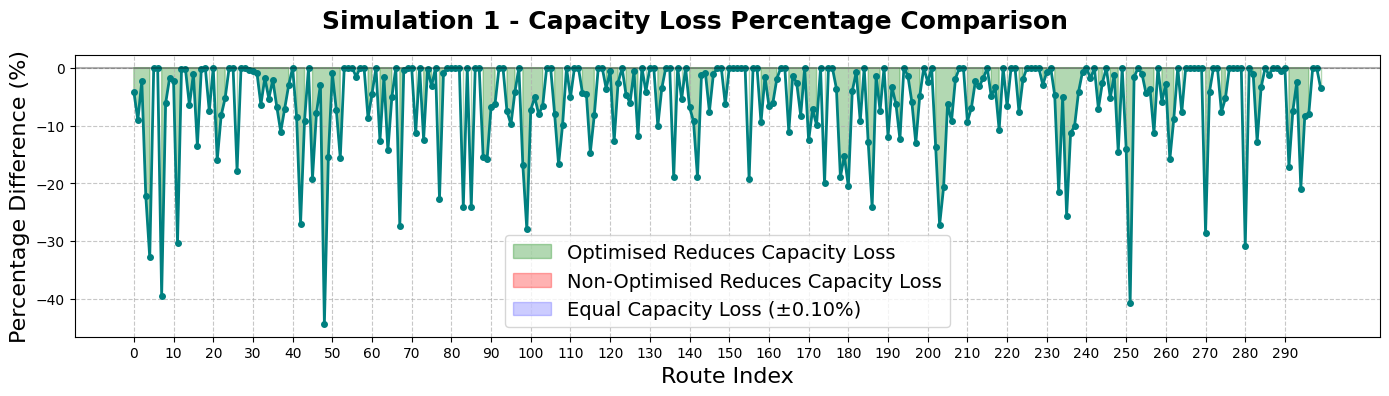

Data points: 300
Points where optimised is better: 298 (99.3%)
Average percentage difference: -4.48%
Median percentage difference: -1.47%
Routes improved: 63.3%
Routes the same: 36.0%
Routes worsened: 0.7%
Standard deviation: 6.82%
Coefficient of variation: 1.52
95% Confidence interval: [-5.25%, -3.70%]
p-value (paired t-test): 0.000000 (significant)


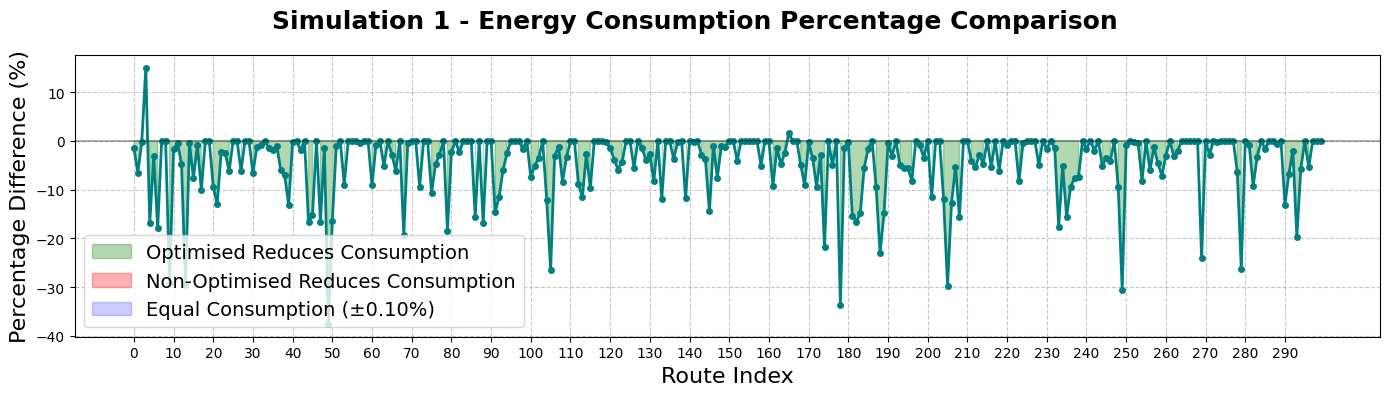

Data points: 300
Points where optimised is better: 300 (100.0%)
Average percentage difference: -6.80%
Median percentage difference: -3.38%
Routes improved: 67.3%
Routes the same: 32.7%
Routes worsened: 0.0%
Standard deviation: 8.64%
Coefficient of variation: 1.27
95% Confidence interval: [-7.78%, -5.82%]
p-value (paired t-test): 0.000000 (significant)


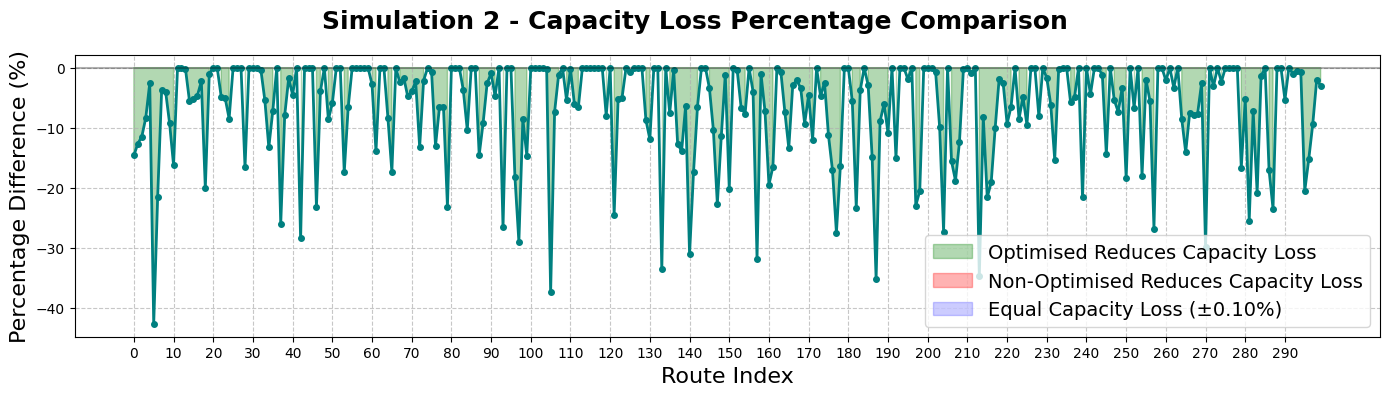

Data points: 300
Points where optimised is better: 291 (97.0%)
Average percentage difference: -4.92%
Median percentage difference: -1.69%
Routes improved: 62.7%
Routes the same: 34.3%
Routes worsened: 3.0%
Standard deviation: 7.93%
Coefficient of variation: 1.61
95% Confidence interval: [-5.82%, -4.02%]
p-value (paired t-test): 0.000000 (significant)


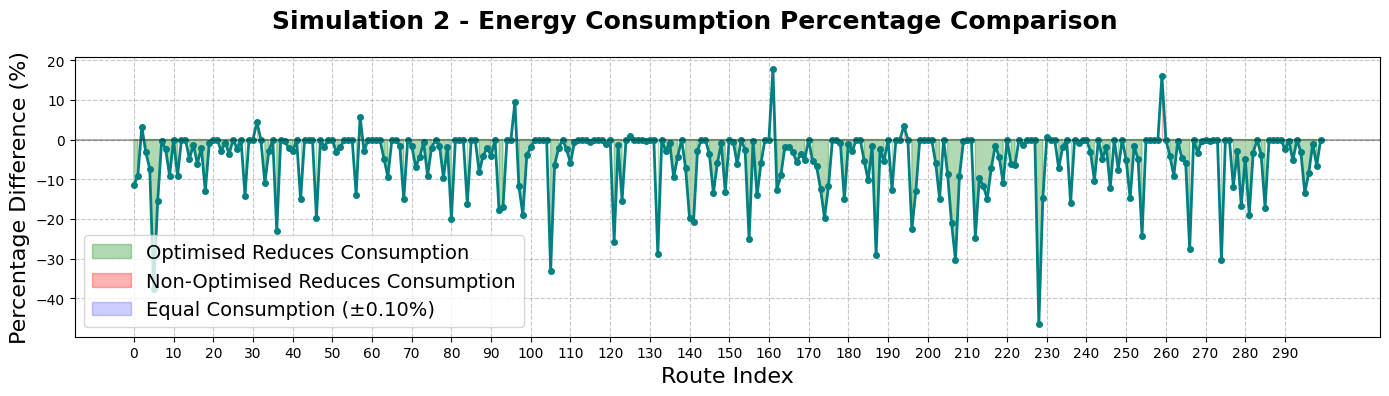

Data points: 300
Points where optimised is better: 300 (100.0%)
Average percentage difference: -5.59%
Median percentage difference: -2.57%
Routes improved: 68.3%
Routes the same: 31.7%
Routes worsened: 0.0%
Standard deviation: 7.38%
Coefficient of variation: 1.32
95% Confidence interval: [-6.43%, -4.75%]
p-value (paired t-test): 0.000000 (significant)


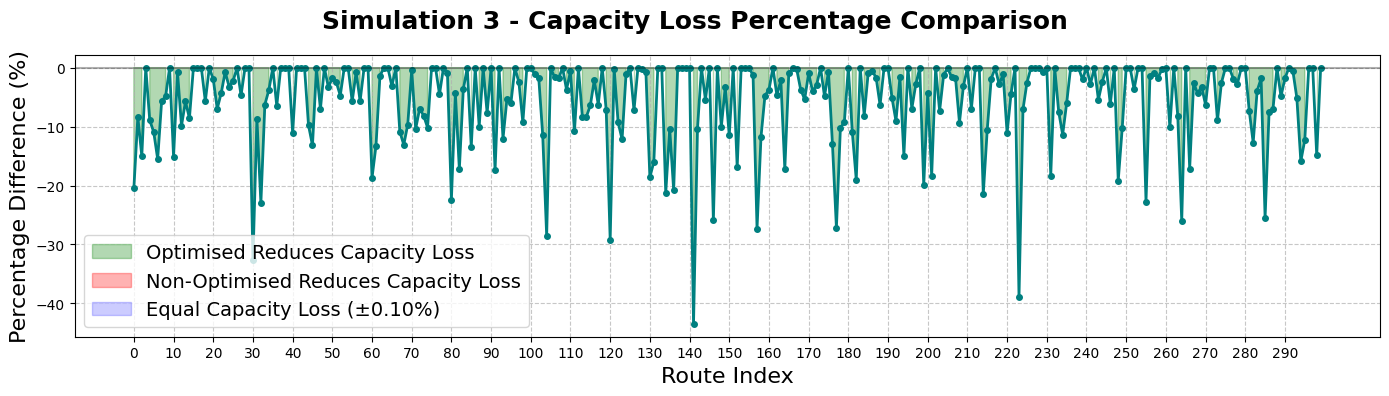

Data points: 300
Points where optimised is better: 286 (95.3%)
Average percentage difference: -3.69%
Median percentage difference: -1.65%
Routes improved: 62.7%
Routes the same: 32.7%
Routes worsened: 4.7%
Standard deviation: 5.80%
Coefficient of variation: 1.57
95% Confidence interval: [-4.35%, -3.03%]
p-value (paired t-test): 0.000000 (significant)


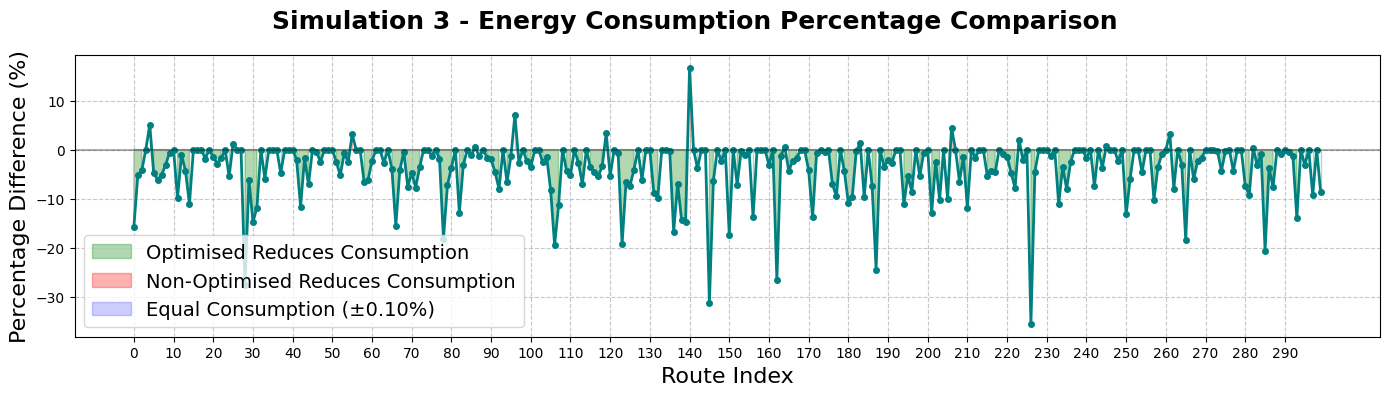

Data points: 300
Points where optimised is better: 300 (100.0%)
Average percentage difference: -6.92%
Median percentage difference: -3.39%
Routes improved: 65.3%
Routes the same: 34.7%
Routes worsened: 0.0%
Standard deviation: 9.14%
Coefficient of variation: 1.32
95% Confidence interval: [-7.96%, -5.88%]
p-value (paired t-test): 0.000000 (significant)


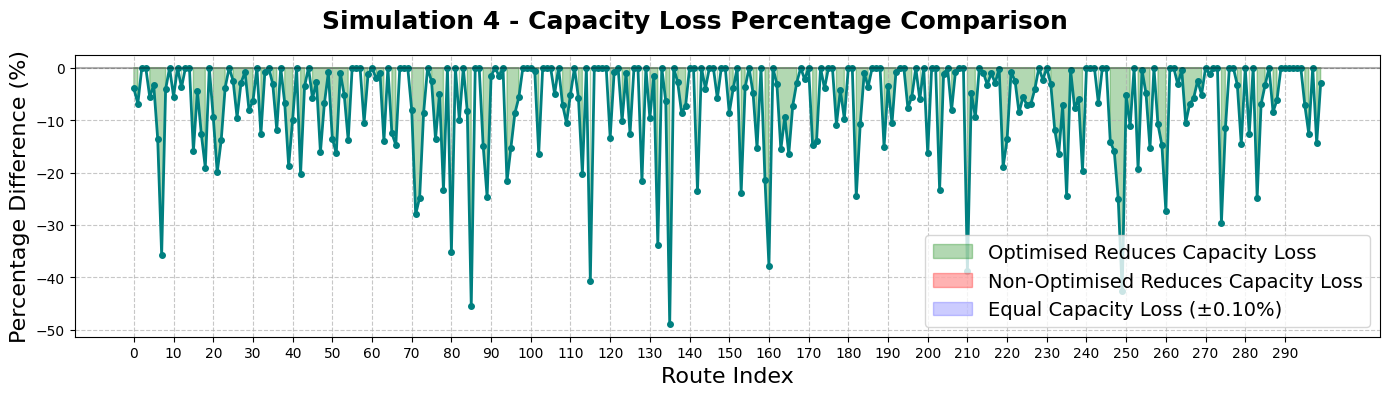

Data points: 300
Points where optimised is better: 300 (100.0%)
Average percentage difference: -4.75%
Median percentage difference: -1.47%
Routes improved: 60.3%
Routes the same: 39.7%
Routes worsened: 0.0%
Standard deviation: 7.19%
Coefficient of variation: 1.51
95% Confidence interval: [-5.57%, -3.94%]
p-value (paired t-test): 0.000000 (significant)


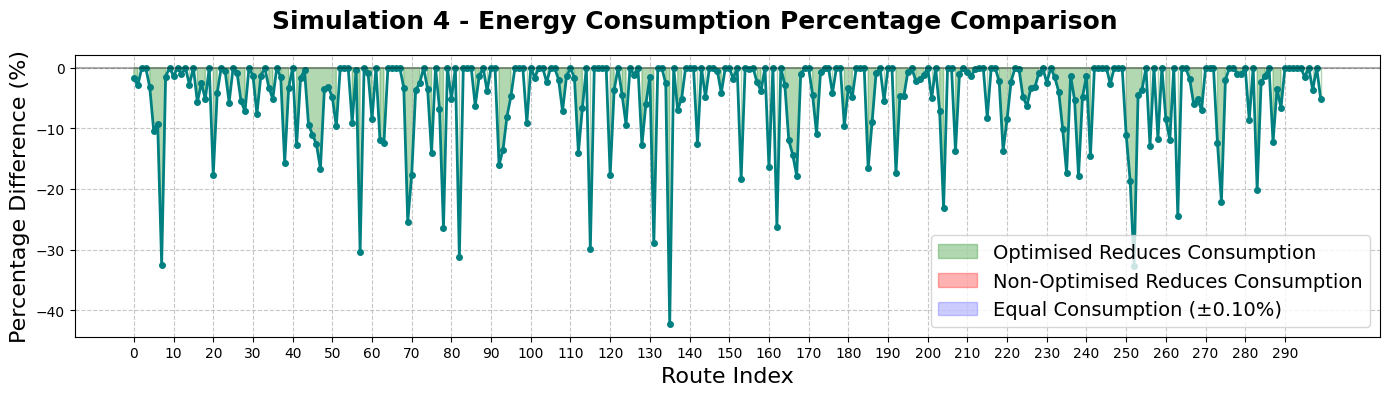

Data points: 300
Points where optimised is better: 300 (100.0%)
Average percentage difference: -5.90%
Median percentage difference: -1.46%
Routes improved: 62.0%
Routes the same: 38.0%
Routes worsened: 0.0%
Standard deviation: 8.36%
Coefficient of variation: 1.42
95% Confidence interval: [-6.85%, -4.95%]
p-value (paired t-test): 0.000000 (significant)


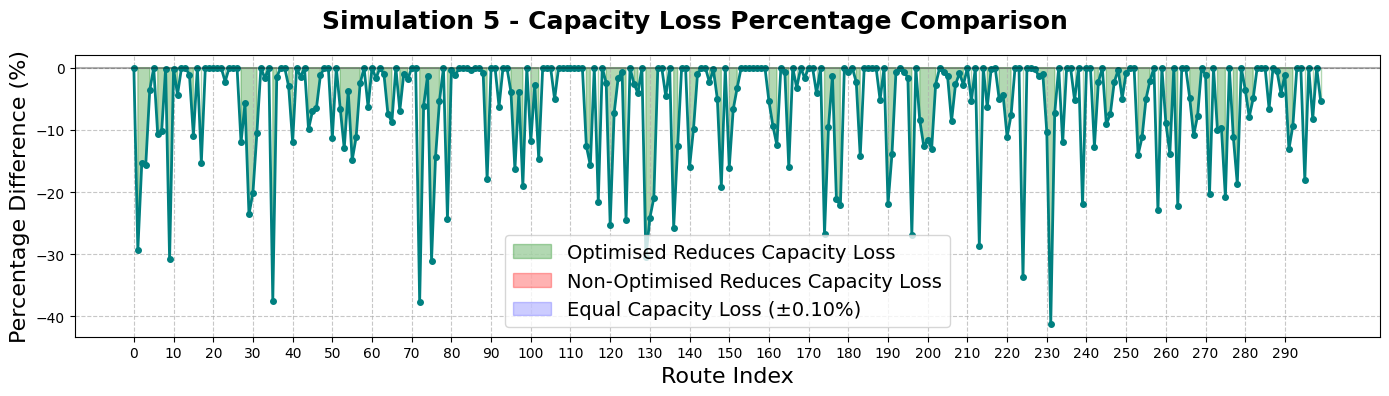

Data points: 300
Points where optimised is better: 300 (100.0%)
Average percentage difference: -4.47%
Median percentage difference: -1.22%
Routes improved: 59.3%
Routes the same: 40.7%
Routes worsened: 0.0%
Standard deviation: 6.75%
Coefficient of variation: 1.51
95% Confidence interval: [-5.24%, -3.71%]
p-value (paired t-test): 0.000000 (significant)


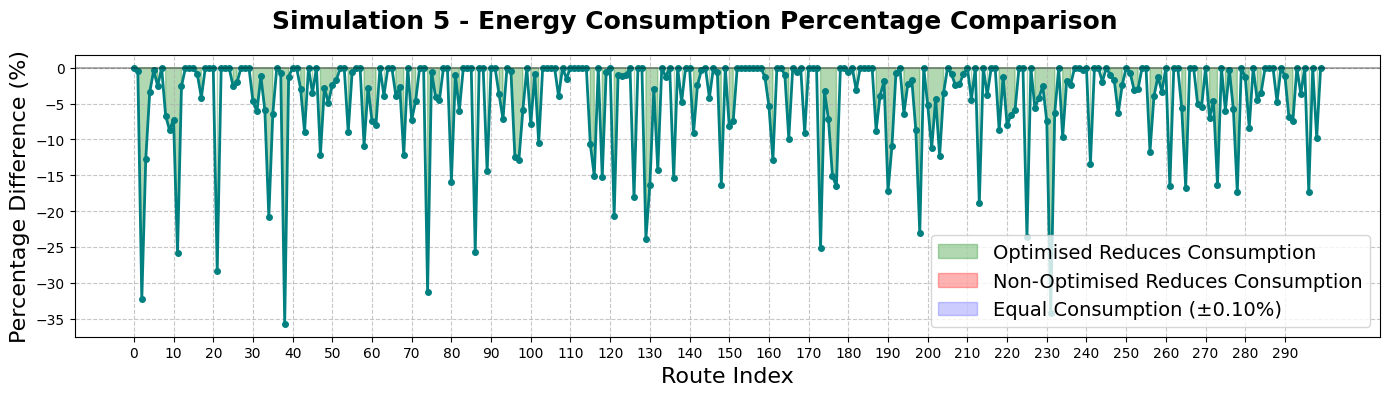

In [177]:
# simulation1 = "results/singular_routes_sim/simulation_test_set1.json"
# simulation2 = "results/singular_routes_sim/simulation_test_set2.json"
# simulation3 = "results/singular_routes_sim/simulation_test_set3.json"
# simulation4 = "results/singular_routes_sim/simulation_test_set4.json"
# simulation5 = "results/singular_routes_sim/simulation_test_set5.json"

# sims = [simulation1,simulation2,simulation3,simulation4,simulation5]

# for sim in sims:
#     analyse_simulation_cap_loss(sim)
#     analyse_simulation_consumption(sim)

# Example of how to use the modified functions
results_file = "route_simulation_results.txt"
with open(results_file, 'w') as f:
    f.write("Simulation Results Summary\n")
    f.write("=========================\n\n")

simulation1 = "results/singular_routes_sim/simulation_test_set1.json"
simulation2 = "results/singular_routes_sim/simulation_test_set2.json"
simulation3 = "results/singular_routes_sim/simulation_test_set3.json"
simulation4 = "results/singular_routes_sim/simulation_test_set4.json"
simulation5 = "results/singular_routes_sim/simulation_test_set5.json"
sims = [simulation1, simulation2, simulation3, simulation4, simulation5]

for sim in sims:
    analyse_simulation_cap_loss(sim, results_file)
    analyse_simulation_consumption(sim, results_file)

==================== OVERALL SUMMARY ====================
Total simulations analyzed: 5
Types of metrics: capacity, consumption


==================== SUMMARY BY METRIC TYPE ====================

--- CAPACITY RESULTS ---
Average improvement across all simulations: -6.23%
Range: -6.92% to -5.59%
Average percentage of routes improved: 66.0%
Average percentage of routes the same: 34.0%
Average percentage of routes worsened: 0.0%
Number of statistically significant results: 5 out of 5

--- CONSUMPTION RESULTS ---
Average improvement across all simulations: -4.46%
Range: -4.92% to -3.69%
Average percentage of routes improved: 61.7%
Average percentage of routes the same: 36.7%
Average percentage of routes worsened: 1.7%
Number of statistically significant results: 5 out of 5


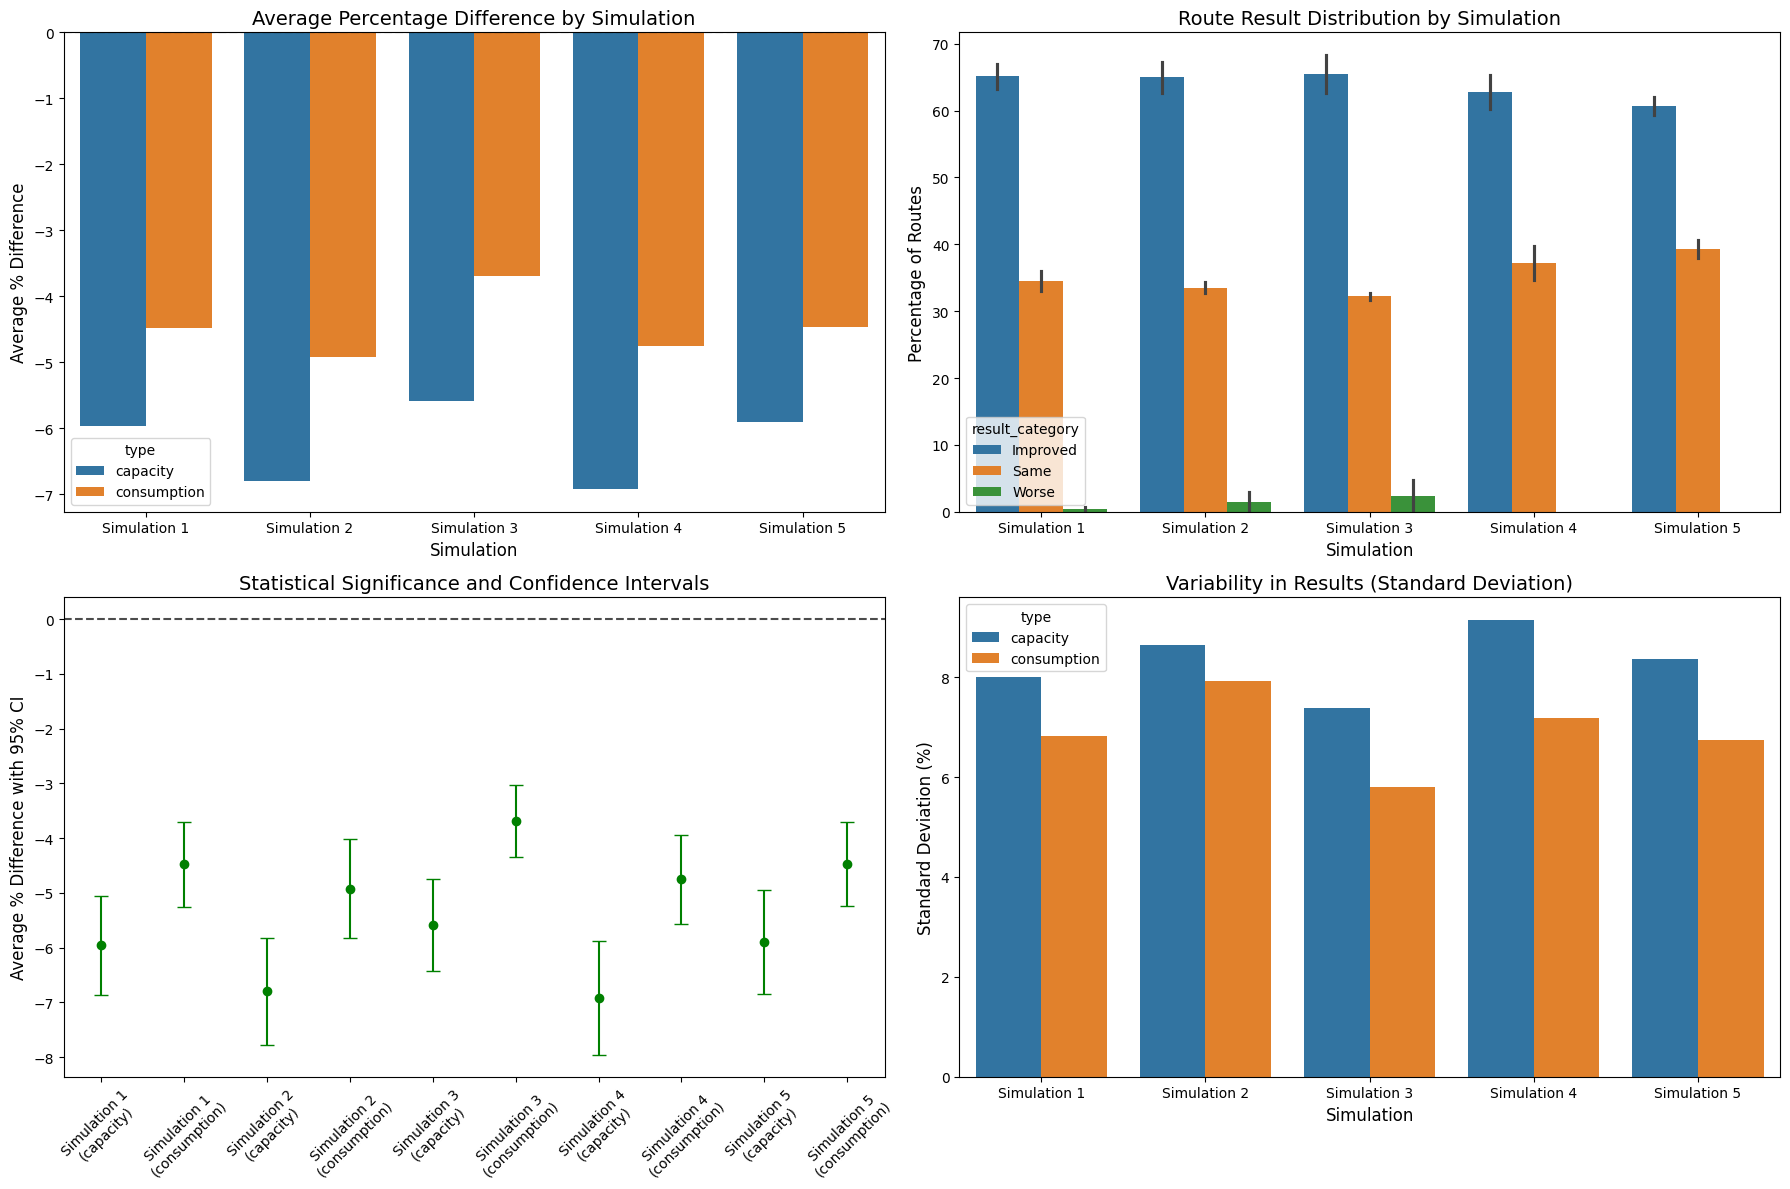


==================== DETAILED RESULTS TABLE ====================
  Simulation Metric Type Avg Diff Median Diff Improved  Same Worse Std Dev  p-value Significant
Simulation 1    capacity   -5.96%      -2.89%    67.0% 33.0%  0.0%   8.00% 0.000000         Yes
Simulation 1 consumption   -4.48%      -1.47%    63.3% 36.0%  0.7%   6.82% 0.000000         Yes
Simulation 2    capacity   -6.80%      -3.38%    67.3% 32.7%  0.0%   8.64% 0.000000         Yes
Simulation 2 consumption   -4.92%      -1.69%    62.7% 34.3%  3.0%   7.93% 0.000000         Yes
Simulation 3    capacity   -5.59%      -2.57%    68.3% 31.7%  0.0%   7.38% 0.000000         Yes
Simulation 3 consumption   -3.69%      -1.65%    62.7% 32.7%  4.7%   5.80% 0.000000         Yes
Simulation 4    capacity   -6.92%      -3.39%    65.3% 34.7%  0.0%   9.14% 0.000000         Yes
Simulation 4 consumption   -4.75%      -1.47%    60.3% 39.7%  0.0%   7.19% 0.000000         Yes
Simulation 5    capacity   -5.90%      -1.46%    62.0% 38.0%  0.0%   8

In [179]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

def parse_results_file(file_path):
    """
    Parse the simulation results text file and extract key metrics.
    """
    with open(file_path, 'r') as f:
        content = f.read()
    
    # Regex patterns to extract data
    sim_pattern = r'(Simulation \d+):'
    result_type_pattern = r'(capacity|consumption) results'
    avg_pattern = r'Average percentage difference: ([-\d\.]+)%'
    median_pattern = r'Median percentage difference: ([-\d\.]+)%'
    improved_pattern = r'Routes improved: ([\d\.]+)%'
    same_pattern = r'Routes the same: ([\d\.]+)%'
    worse_pattern = r'Routes worsened: ([\d\.]+)%'
    std_pattern = r'Standard deviation: ([\d\.]+)%'
    cv_pattern = r'Coefficient of variation: ([\d\.]+)'
    ci_pattern = r'\[(-?[\d\.]+)%, (-?[\d\.]+)%\]'
    pvalue_pattern = r'p-value \(paired t-test\): ([\d\.e-]+)'
    
    # Split the content by simulation blocks
    results = []
    
    # Current simulation and result type
    current_sim = None
    current_type = None
    
    # Process each line
    lines = content.split('\n')
    for line in lines:
        # Check for new simulation
        sim_match = re.search(sim_pattern, line)
        if sim_match:
            current_sim = sim_match.group(1)
            continue
            
        # Check for result type
        type_match = re.search(result_type_pattern, line)
        if type_match:
            current_type = type_match.group(1)
            continue
            
        # Extract metrics
        avg_match = re.search(avg_pattern, line)
        if avg_match and current_sim and current_type:
            avg_value = float(avg_match.group(1))
            
            # Find the corresponding metrics in the nearby lines
            block_start = lines.index(line)
            block_end = min(block_start + 10, len(lines))
            block = '\n'.join(lines[block_start:block_end])
            
            median_match = re.search(median_pattern, block)
            improved_match = re.search(improved_pattern, block)
            same_match = re.search(same_pattern, block)
            worse_match = re.search(worse_pattern, block)
            std_match = re.search(std_pattern, block)
            cv_match = re.search(cv_pattern, block)
            ci_match = re.search(ci_pattern, block)
            pvalue_match = re.search(pvalue_pattern, block)
            
            result = {
                'simulation': current_sim,
                'type': current_type,
                'avg_diff': avg_value,
                'median_diff': float(median_match.group(1)) if median_match else None,
                'improved_percent': float(improved_match.group(1)) if improved_match else None,
                'same_percent': float(same_match.group(1)) if same_match else None,
                'worse_percent': float(worse_match.group(1)) if worse_match else None,
                'std_dev': float(std_match.group(1)) if std_match else None,
                'cv': float(cv_match.group(1)) if cv_match else None,
                'ci_lower': float(ci_match.group(1)) if ci_match else None,
                'ci_upper': float(ci_match.group(2)) if ci_match else None,
                'p_value': float(pvalue_match.group(1)) if pvalue_match else None,
                'significant': 'Yes' if pvalue_match and float(pvalue_match.group(1)) < 0.05 else 'No'
            }
            
            results.append(result)
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    return df

def analyze_results(df):
    """
    Analyze the parsed results and create summary visualizations.
    """
    # Create overall summary
    print("==================== OVERALL SUMMARY ====================")
    print(f"Total simulations analyzed: {df['simulation'].nunique()}")
    print(f"Types of metrics: {', '.join(df['type'].unique())}")
    print("\n")
    
    # Summary statistics by type
    print("==================== SUMMARY BY METRIC TYPE ====================")
    for metric_type in df['type'].unique():
        type_df = df[df['type'] == metric_type]
        print(f"\n--- {metric_type.upper()} RESULTS ---")
        print(f"Average improvement across all simulations: {type_df['avg_diff'].mean():.2f}%")
        print(f"Range: {type_df['avg_diff'].min():.2f}% to {type_df['avg_diff'].max():.2f}%")
        print(f"Average percentage of routes improved: {type_df['improved_percent'].mean():.1f}%")
        print(f"Average percentage of routes the same: {type_df['same_percent'].mean():.1f}%")
        print(f"Average percentage of routes worsened: {type_df['worse_percent'].mean():.1f}%")
        print(f"Number of statistically significant results: {(type_df['significant'] == 'Yes').sum()} out of {len(type_df)}")
    
    # Create visualization
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(2, 2, figure=fig)
    
    # 1. Average percentage difference by simulation and type
    ax1 = fig.add_subplot(gs[0, 0])
    sns.barplot(x='simulation', y='avg_diff', hue='type', data=df, ax=ax1)
    ax1.set_title('Average Percentage Difference by Simulation', fontsize=14)
    ax1.set_xlabel('Simulation', fontsize=12)
    ax1.set_ylabel('Average % Difference', fontsize=12)
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.7)
    
    # 2. Routes improved/same/worse distribution
    ax2 = fig.add_subplot(gs[0, 1])
    melted_df = pd.melt(df, 
                        id_vars=['simulation', 'type'], 
                        value_vars=['improved_percent', 'same_percent', 'worse_percent'],
                        var_name='result_category', value_name='percentage')
    melted_df['result_category'] = melted_df['result_category'].map({
        'improved_percent': 'Improved',
        'same_percent': 'Same',
        'worse_percent': 'Worse'
    })
    sns.barplot(x='simulation', y='percentage', hue='result_category', data=melted_df, ax=ax2)
    ax2.set_title('Route Result Distribution by Simulation', fontsize=14)
    ax2.set_xlabel('Simulation', fontsize=12)
    ax2.set_ylabel('Percentage of Routes', fontsize=12)
    
    # 3. Statistical significance and confidence intervals
    ax3 = fig.add_subplot(gs[1, 0])
    for i, row in df.iterrows():
        color = 'green' if row['avg_diff'] < 0 else 'red'
        alpha = 1.0 if row['significant'] == 'Yes' else 0.5
        ax3.errorbar(x=i, y=row['avg_diff'], 
                    yerr=[[abs(row['ci_lower'] - row['avg_diff'])], [abs(row['ci_upper'] - row['avg_diff'])]],
                    fmt='o', color=color, alpha=alpha, capsize=5)
    ax3.set_title('Statistical Significance and Confidence Intervals', fontsize=14)
    ax3.set_xticks(range(len(df)))
    ax3.set_xticklabels([f"{row['simulation']}\n({row['type']})" for _, row in df.iterrows()], rotation=45)
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.7)
    ax3.set_ylabel('Average % Difference with 95% CI', fontsize=12)
    
    # 4. Standard deviation comparison
    ax4 = fig.add_subplot(gs[1, 1])
    sns.barplot(x='simulation', y='std_dev', hue='type', data=df, ax=ax4)
    ax4.set_title('Variability in Results (Standard Deviation)', fontsize=14)
    ax4.set_xlabel('Simulation', fontsize=12)
    ax4.set_ylabel('Standard Deviation (%)', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('simulation_analysis_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Table view of full results
    styled_df = df[['simulation', 'type', 'avg_diff', 'median_diff', 
                   'improved_percent', 'same_percent', 'worse_percent', 
                   'std_dev', 'p_value', 'significant']].copy()
    
    # Format the values for better readability
    styled_df['avg_diff'] = styled_df['avg_diff'].apply(lambda x: f"{x:.2f}%")
    styled_df['median_diff'] = styled_df['median_diff'].apply(lambda x: f"{x:.2f}%")
    styled_df['improved_percent'] = styled_df['improved_percent'].apply(lambda x: f"{x:.1f}%")
    styled_df['same_percent'] = styled_df['same_percent'].apply(lambda x: f"{x:.1f}%")
    styled_df['worse_percent'] = styled_df['worse_percent'].apply(lambda x: f"{x:.1f}%")
    styled_df['std_dev'] = styled_df['std_dev'].apply(lambda x: f"{x:.2f}%")
    styled_df['p_value'] = styled_df['p_value'].apply(lambda x: f"{x:.6f}")
    
    styled_df.columns = ['Simulation', 'Metric Type', 'Avg Diff', 'Median Diff', 
                         'Improved', 'Same', 'Worse', 'Std Dev', 'p-value', 'Significant']
    
    print("\n==================== DETAILED RESULTS TABLE ====================")
    print(styled_df.to_string(index=False))
    
    # Save table to CSV
    styled_df.to_csv('simulation_results_summary.csv', index=False)
    
    return styled_df

def compare_capacity_vs_consumption():
    """
    Generate additional analysis comparing capacity and consumption metrics.
    """
    # This would be implemented based on specific needs
    pass

# Main execution
if __name__ == "__main__":
    # Parse the results file
    results_file = "route_simulation_results.txt"  # Change to your file path
    df = parse_results_file(results_file)
    
    # Analyze the results
    summary_df = analyze_results(df)
    
    # You can add more specific analyses here
    # compare_capacity_vs_consumption()